In [2]:
from sdm.utils import set_project_wd
set_project_wd()

Current Working Directory: /Users/matthewwhittle/Data Science/shefflied-bats


In [3]:
import xarray as xr
import geopandas as gpd
import nest_asyncio
nest_asyncio.apply()

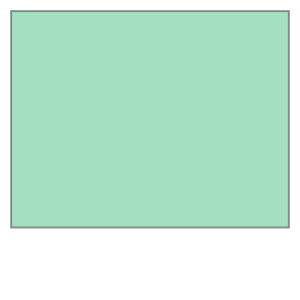

In [4]:
import rioxarray as rxr
import xarray as xr
from shapely.geometry import box
import geopandas as gpd


s2_image = xr.open_mfdataset("data/raw/big-files/sentinel-2/*.tif", engine="rasterio", chunks = "auto")
bbox = s2_image.rio.bounds()

boundary = gpd.GeoDataFrame({"geometry": [box(*bbox)]}, crs=s2_image.rio.crs)
boundary = boundary.to_crs("EPSG:27700")

boundary.geometry[0]

# Download the EA Vegetation Height data

In [5]:
from sdm.extract import ImageTileDownloader

downloader = ImageTileDownloader(
    base_url="https://environment.data.gov.uk/image/rest/services/SURVEY/VegetationObjectModel/ImageServer",
    cache_folder="data/raw/big-files/vegetation-height-cache",
)
# downloader.clear_cache()

In [6]:
dl_resolution = 10
image = downloader.download_image(
    polygon = boundary.geometry[0],
    target_resolution=dl_resolution
    )

# Tidy up the data

In [7]:
image

<xarray.DataArray 'VegetationObjectModel' (y: 10000, x: 12000)>
dask.array<getitem, shape=(10000, 12000), dtype=float32, chunksize=(2000, 2000), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 3.908e+05 3.908e+05 ... 5.108e+05 5.108e+05
  * y            (y) float64 4.573e+05 4.573e+05 ... 3.573e+05 3.573e+05
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:    Area
    DataType:         Generic
    SourceBandIndex:  0

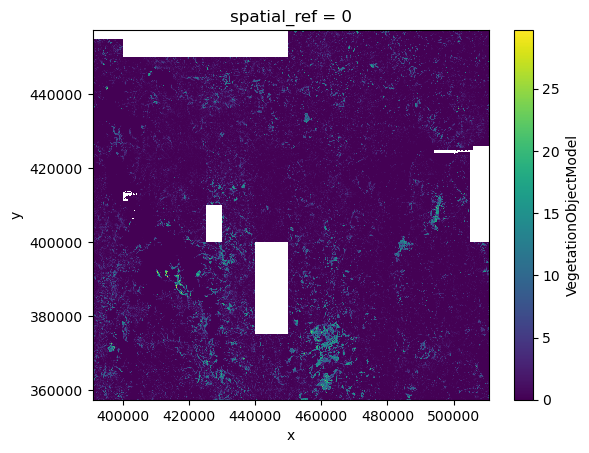

In [8]:
image_coarse = image.coarsen(x=10, y=10).mean()
image_coarse.plot()

In [9]:
# Write some data for modelling
image.rio.to_raster("data/processed/vegetation-height.tif")

# Summary Stats

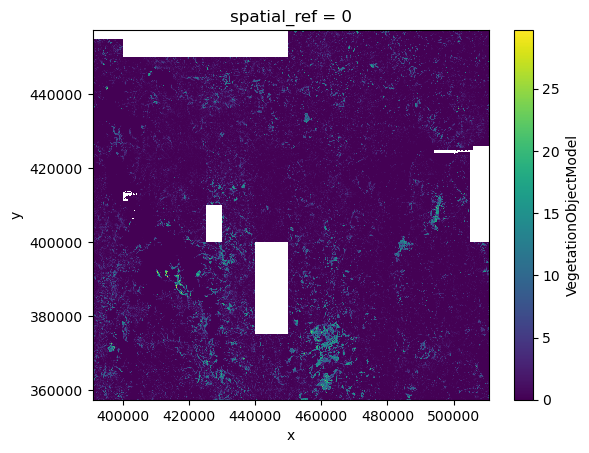

In [10]:
# Generate statistics from the image (std dev, mean, max, min etc) do it at 100 m resolution (factor 100)
target_resolution = 100
factor = round(target_resolution / dl_resolution)
image_100m = image.coarsen(x=factor, y=factor)
image_100m_mean = image_100m.mean()
image_100m_std = image_100m.std()
image_100m_max = image_100m.max()
image_100m_min = image_100m.min()

# Plot the mean vegetation height
image_100m_mean.plot()

In [11]:
image_100m_min

<xarray.DataArray 'VegetationObjectModel' (y: 1000, x: 1200)>
dask.array<_nanmin_skip-aggregate, shape=(1000, 1200), dtype=float32, chunksize=(200, 200), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 3.908e+05 3.91e+05 3.91e+05 ... 5.106e+05 5.108e+05
  * y            (y) float64 4.573e+05 4.572e+05 ... 3.575e+05 3.574e+05
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:    Area
    DataType:         Generic
    SourceBandIndex:  0

In [12]:

# Generate a multi band image with the mean, std dev, max and min
layers = [image_100m_mean, image_100m_std, image_100m_max, image_100m_min]
names = ["vegetation_height_mean", "vegetation_height_std", "vegetation_height_max", "vegetation_height_min"]

image_100m_stats = xr.concat(layers, dim="band")
image_100m_stats["band"]  = names
image_100m_stats

<xarray.DataArray 'VegetationObjectModel' (band: 4, y: 1000, x: 1200)>
dask.array<concatenate, shape=(4, 1000, 1200), dtype=float32, chunksize=(1, 200, 200), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 3.908e+05 3.91e+05 3.91e+05 ... 5.106e+05 5.108e+05
  * y            (y) float64 4.573e+05 4.572e+05 ... 3.575e+05 3.574e+05
    spatial_ref  int64 0
  * band         (band) <U22 'vegetation_height_mean' ... 'vegetation_height_...
Attributes:
    AREA_OR_POINT:    Area
    DataType:         Generic
    SourceBandIndex:  0

# Write Data

In [21]:
image_100m_stats.attrs["long_name"] = tuple(image_100m_stats.coords["band"].values)
from sdm.geo import reproject_to_model_raster
image_100m_stats = reproject_to_model_raster(image_100m_stats)

/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.1

In [22]:
image_100m_stats.rio.to_raster("data/evs/vegetation-height.tif")